In [1]:
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
from matplotlib.pyplot import figure
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.cuda.empty_cache()
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
import seaborn as sns
import re

sns.set()
plt.rc('font', family = 'serif')

In [2]:
def get_binary_testset(dataset_name):
    """
    dataset_name -> trainset, valset, testset
    """
    trainset, valset, testset = None, None, None
    dataset_name = dataset_name.lower()
    path_2_root = "../.."

    if not "oc" in dataset_name:
        if "dar" in dataset_name and "oc" not in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/validation"

        if "avg" in dataset_name: # Celeb-avg-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_avg"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_avg"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_avg"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_avg"

        elif "rnd" in dataset_name: # Celeb-rnd-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_rnd"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_rnd"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_rnd"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_rnd"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_rnd"

        elif "diff" in dataset_name: # Celeb-diff-30
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

    else: # oc
        if "dar" in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/" # unary
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/" # binary

        elif "avg" in dataset_name:
            pass

        elif "rnd" in dataset_name: # Celeb-rnd-30-OC
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/" # unary
            valset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"  # unary
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/" # binary

    testset = trainset if testset==None else testset
    valset = trainset if valset==None else valset
    return trainset, valset, testset

In [3]:
trainset, valset, testset = get_binary_testset("Celeb-rnd") 
dataset_name =  "RND"

In [4]:
batch_size = 128
epochs = 300
img_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(25 * 25 * 32, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.fc2_mean = nn.Linear(1000, 100)
        self.fc2_logvar = nn.Linear(1000, 100)

        self.fc3 = nn.Linear(100, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        self.fc4 = nn.Linear(1000, 25 * 25 * 32)
        self.fc4_bn = nn.BatchNorm1d(25 * 25 * 32)

        self.relu = nn.ReLU()

        self.conv5 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        
    def encode(self, data):
        conv1 = self.relu(self.bn1(self.conv1(data)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3)))

        fc1 = self.relu(self.fc1_bn(self.fc1(conv4.view(-1, 25 * 25 * 32))))
        mean = self.fc2_mean(fc1)
        logvar = self.fc2_logvar(fc1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = 0.5 * torch.exp(logvar)
        z = (std.data.new(std.size()).normal_()) * std + mean
        return z
    
    def decode(self, z):
        fc3 = self.relu(self.fc3_bn(self.fc3(z)))
        fc4 = self.relu(self.fc4_bn(self.fc4(fc3)))
        conv5 = self.relu(self.bn5(self.conv5(fc4.view(-1, 32, 25, 25))))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        conv8 = self.conv8(conv7)
        return conv8.view(-1, 3, img_size, img_size)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

def loss_function(recon_x, x, mean, logvar):
    mse_loss = nn.MSELoss(reduction="sum")
    reconstruction_loss = mse_loss(recon_x, x)
    kld_loss = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mean**2)
    return reconstruction_loss + kld_loss

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(trainset, 
                         transform=transform_train),
                         batch_size=batch_size, 
                         shuffle=True,
                         drop_last = True)
fakedect = vae().to(device)

num_steps = len(train_loader) * epochs
optimizer = optim.Adam(fakedect.parameters(), lr=1e-4)
print(summary(fakedect, (3, img_size, img_size)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 100]        432
├─BatchNorm2d: 1-2                       [-1, 16, 100, 100]        32
├─ReLU: 1-3                              [-1, 16, 100, 100]        --
├─Conv2d: 1-4                            [-1, 32, 50, 50]          4,608
├─BatchNorm2d: 1-5                       [-1, 32, 50, 50]          64
├─ReLU: 1-6                              [-1, 32, 50, 50]          --
├─Conv2d: 1-7                            [-1, 64, 50, 50]          18,432
├─BatchNorm2d: 1-8                       [-1, 64, 50, 50]          128
├─ReLU: 1-9                              [-1, 64, 50, 50]          --
├─Conv2d: 1-10                           [-1, 32, 25, 25]          18,432
├─BatchNorm2d: 1-11                      [-1, 32, 25, 25]          64
├─ReLU: 1-12                             [-1, 32, 25, 25]          --
├─Linear: 1-13                           [-1, 1000]                20,00

In [8]:
history = []

early_stop_coutner = 0
weights_path = f"../../_WEIGHTS/oc_fakedect/OC_FD_e29_l500_AVG.pkl"
fakedect = torch.load(weights_path)

n_dpoints = len(train_loader.dataset)
min_loss = float("inf")
for epoch in range(epochs):#tqdm(range(epochs), total=epochs):
    fakedect.train() # train mode
    train_loss = 0
    for batch_idx, (inputs, _) in tqdm(enumerate(train_loader), total=n_dpoints//batch_size-1):
        inputs = inputs.to(device)
        gen_imgs, mean, logvar = fakedect(inputs)
        loss = loss_function(gen_imgs, inputs, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    L = train_loss / n_dpoints
    history += [L]
    print(f"Epoch={epoch}\tloss={L:.4f}")
    if L < min_loss:
        min_loss = L
        torch.save(fakedect, f"../../_WEIGHTS/oc_fakedect/OC_FD_e{epoch+1}_l{int(L)}_{dataset_name}.pkl")
        print(f"../../_WEIGHTS/oc_fakedect/OC_FD_e{epoch+1}_l{int(L)}_{dataset_name}.pkl")
        early_stop_coutner = 0
    else:
        early_stop_coutner += 1
    
    if early_stop_coutner>20:
        break

  0%|          | 0/432 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# load best weights for eval
# weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e29_l500_AVG.pkl"
weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e2_l532_RND.pkl"
fakedect = torch.load(weights_path)

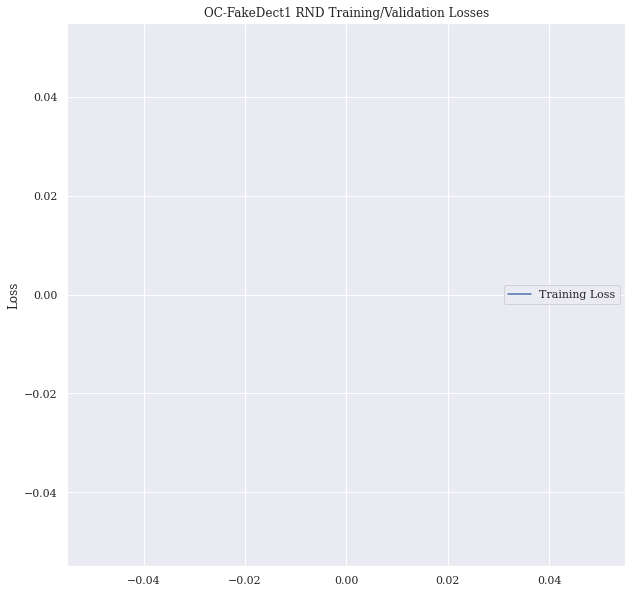

In [10]:
fig, ax = plt.subplots(1, figsize = (10, 10), sharex=True)
ax.plot(history)
ax.set_title(f'OC-FakeDect1 {dataset_name} Training/Validation Losses')
ax.set_ylabel('Loss')
ax.legend(['Training Loss'], loc='center right')
plt.savefig(f"./Results/{dataset_name}_Losses.pdf", dpi=fig.dpi)
plt.show()

In [11]:
# shwcse_img_path = "D:/MInf/Datasets/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/Celeb-real/id11_0009_1.png"
# img = cv2.cvtColor(cv2.imread(shwcse_img_path), cv2.COLOR_BGR2RGB)
# image = transform_test(img)
# image = image.float().to(device)
# # print(image.shape)
# # fakedect = torch.load(weights_path)
# fakedect.eval()
# with torch.no_grad():
#     x = image.view(-1,3,100,100)
#     print(x.shape)
#     decode_z, mean_z, logvar_z = fakedect(x)
#     # print(decode_z.shape )
# decode_z = decode_z.view(3,100,100).cpu()
# decode_z = 255*(decode_z*0.5 + 0.5).numpy()
# decode_z = decode_z.astype(int)
# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.subplot(1,2,2)
# plt.imshow(decode_z.transpose(1,2,0))

In [12]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

In [13]:
              # experiment_name,                                       model_name,          testset_name,                 fname
EXPERIMENTS = [

                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on DFDB Dataset",  f"OC-FakeDect1_{dataset_name}", "DariusAf_Deepfake_Database", f"OC-FakeDect1_{dataset_name}_onDFDB"),

                # OC-FakeDect1 RND on Celebs indep eval
               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_onAVG"),

               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_onRND"),

                # OC-FakeDect1 RND on Celebs rae
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG CDFv2 Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_raeonAVG"),

               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND CDFv2 Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_raeonRND"),

                # OC-FakeDect1 RND on FF indep eval
                # DF
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG Deepfakes Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_raeonDFavg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_DFavg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND Deepfakes Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_raeonDFrnd"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_DFrnd"),

                # F2F
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_raeonF2Favg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_F2Favg"),
              
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_raeonF2Frnd"),
               
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_F2Frnd"),

                # FaceShifter
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceShifter Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_raeonFSHFTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_FSHFTavg"),
               
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceShifter Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSHFTrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_FSHFTrnd"),

                # FaceSwap
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceSwap Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_raeonFSavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_FSavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceSwap Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_FSrnd"),

                # NeuralTextures
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_raeonNTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_NTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_raeonNTrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_NTrnd"),
               ]

OC-FakeDect1 (Trained on RND Dataset) 
Tested on DFDB Dataset
OC-FakeDect1_RND
DariusAf_Deepfake_Database
OC-FakeDect1_RND_onDFDB




100%|██████████| 18038/18038 [01:04<00:00, 280.75it/s]


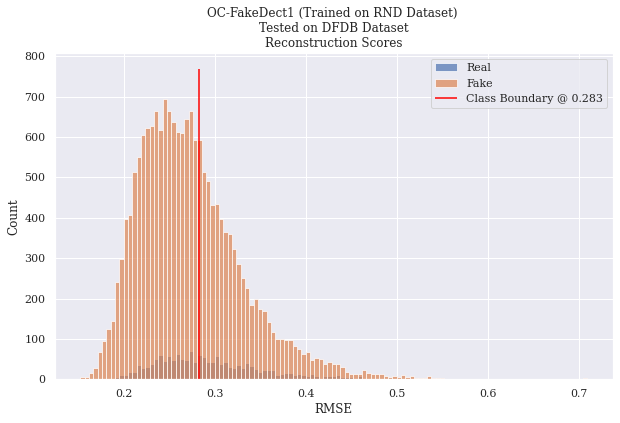

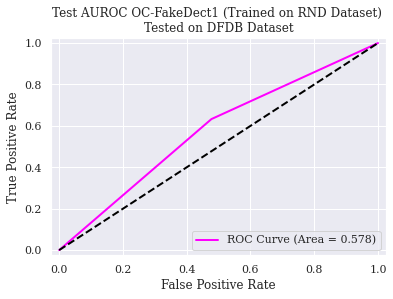

OC-FakeDect1 (Trained on RND Dataset) 
Tested on AVG CDFv2 Dataset
OC-FakeDect1_RND
Celeb-avg-30
OC-FakeDect1_RND_onAVG




100%|██████████| 18038/18038 [01:03<00:00, 285.60it/s]


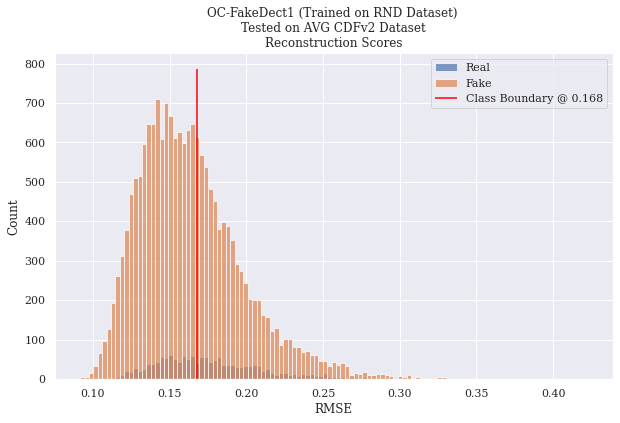

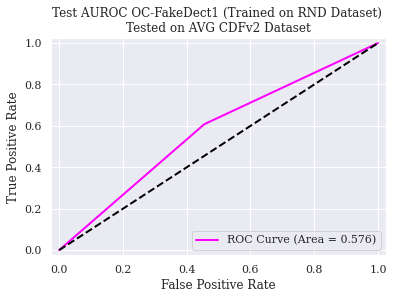

OC-FakeDect1 (Trained on RND Dataset) 
Tested on RND CDFv2 Dataset
OC-FakeDect1_RND
Celeb-rnd-30
OC-FakeDect1_RND_onRND




100%|██████████| 18038/18038 [01:03<00:00, 285.77it/s]


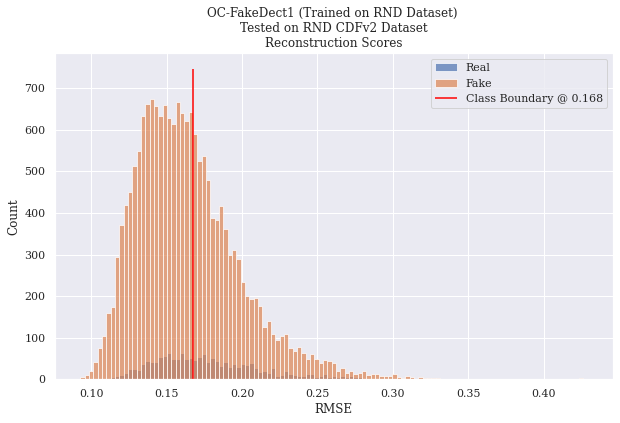

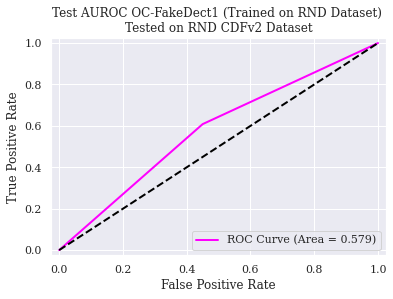

OC-FakeDect1 (Trained on RND Dataset) 
Tested on AVG CDFv2 Dataset 
Running Average Evaluation
OC-FakeDect1_RND
Celeb-avg-30
OC-FakeDect1_RND_raeonAVG




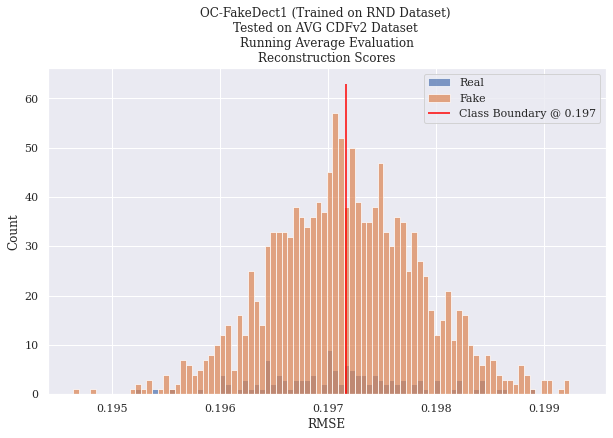

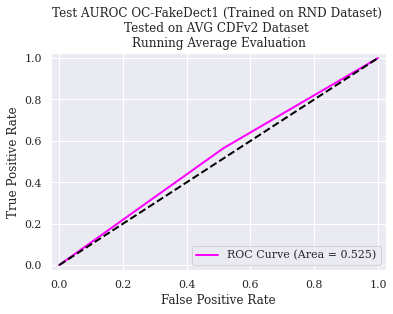

OC-FakeDect1 (Trained on RND Dataset) 
Tested on RND CDFv2 Dataset 
Running Average Evaluation
OC-FakeDect1_RND
Celeb-rnd-30
OC-FakeDect1_RND_raeonRND




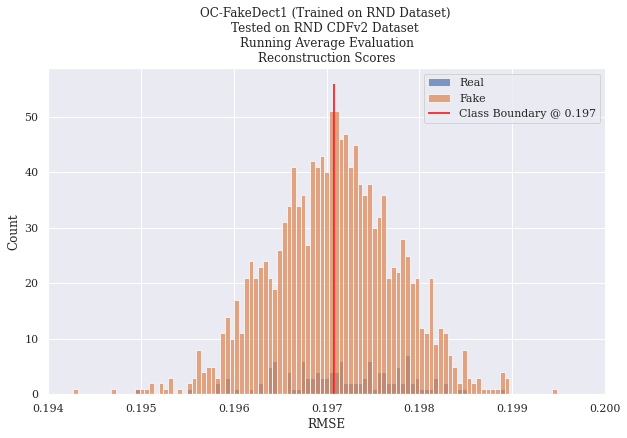

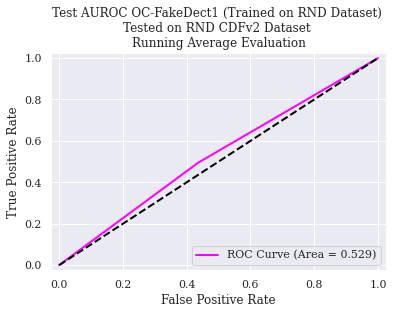

OC-FakeDect1 (Trained on RND Dataset) 
Tested on AVG Deepfakes Dataset 
Running Average Evaluation
OC-FakeDect1_RND
Deepfakes_avg
OC-FakeDect1_RND_raeonDFavg




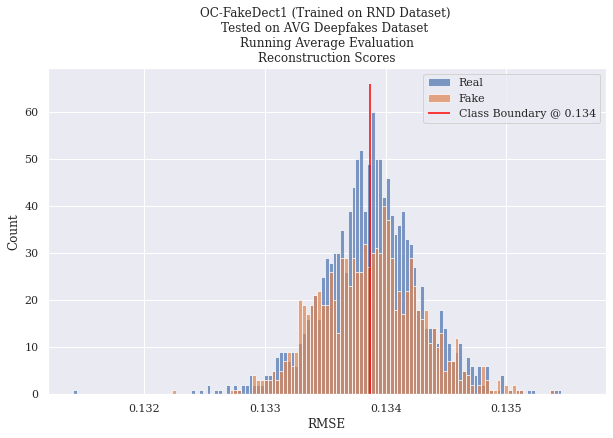

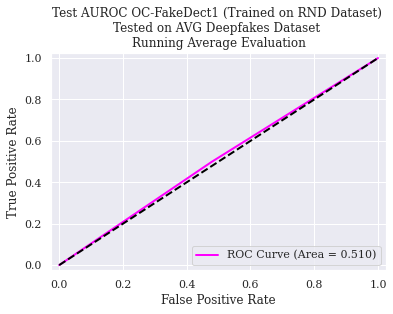

OC-FakeDect1 (Trained on RND Dataset) 
Tested on AVG Deepfakes Dataset
OC-FakeDect1_RND
Deepfakes_avg
OC-FakeDect1_RND_DFavg




100%|██████████| 18038/18038 [01:04<00:00, 281.49it/s]


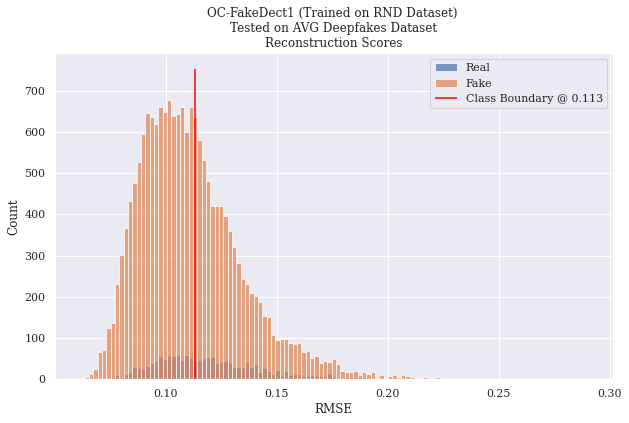

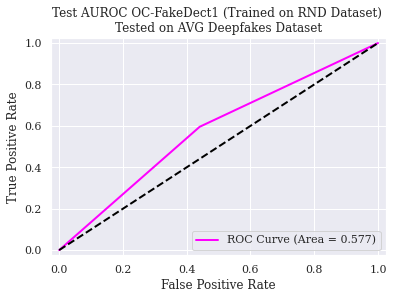

OC-FakeDect1 (Trained on RND Dataset) 
Tested on RND Deepfakes Dataset 
Running Average Evaluation
OC-FakeDect1_RND
Deepfakes_rnd
OC-FakeDect1_RND_raeonDFrnd




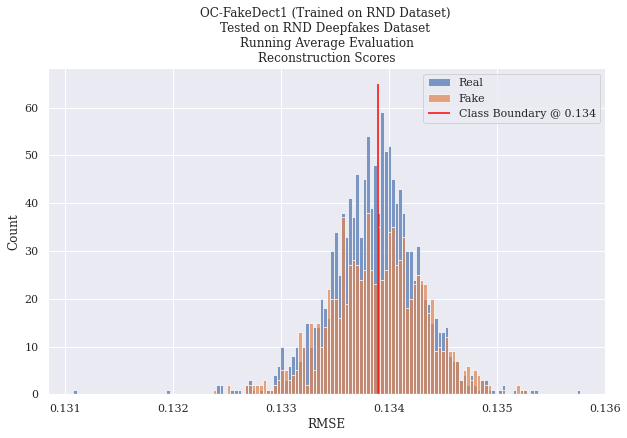

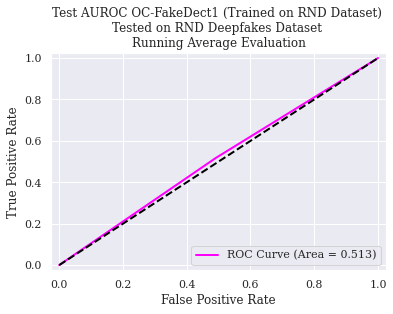

OC-FakeDect1 (Trained on RND Dataset) 
Tested on RND Deepfakes Dataset
OC-FakeDect1_RND
Deepfakes_rnd
OC-FakeDect1_RND_DFrnd




100%|██████████| 18038/18038 [01:04<00:00, 280.74it/s]


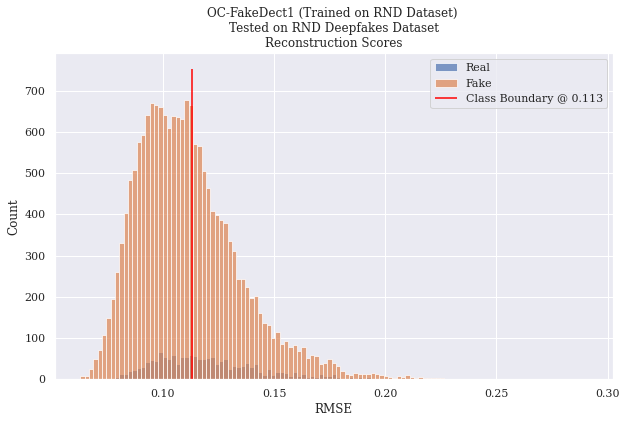

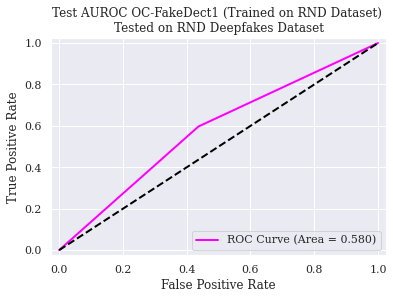

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG Face2Face Dataset  
Running Average Evaluation
OC-FakeDect1_RND
Face2Face_avg
OC-FakeDect1_RND_raeonF2Favg




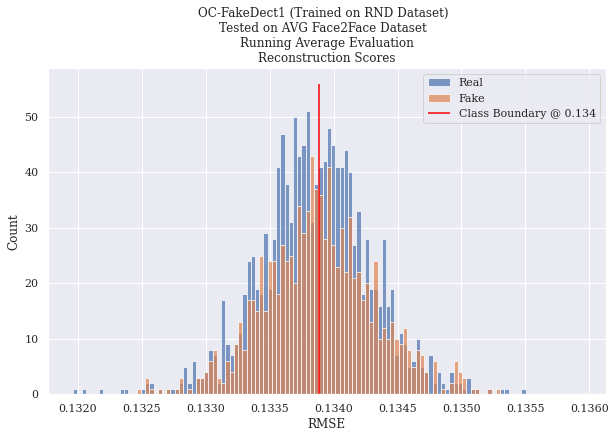

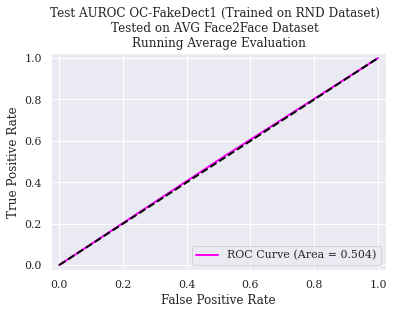

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG Face2Face Dataset
OC-FakeDect1_RND
Face2Face_avg
OC-FakeDect1_RND_F2Favg




100%|██████████| 18038/18038 [01:03<00:00, 281.95it/s]


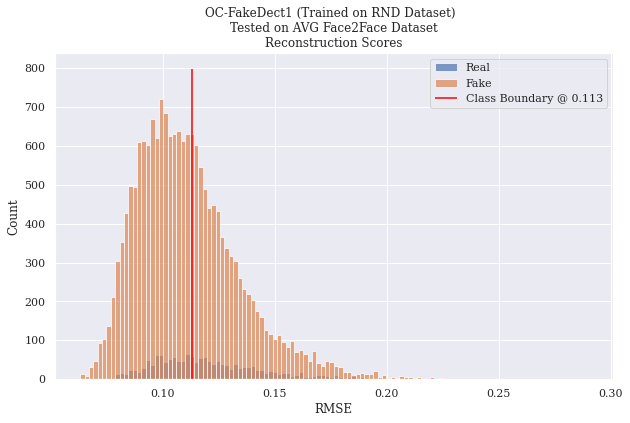

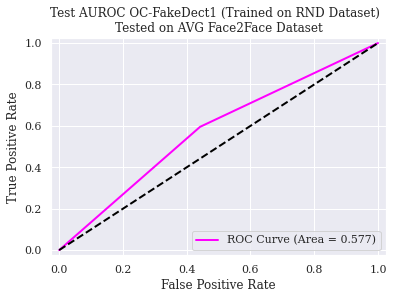

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND Face2Face Dataset  
Running Average Evaluation
OC-FakeDect1_RND
Face2Face_rnd
OC-FakeDect1_RND_raeonF2Frnd




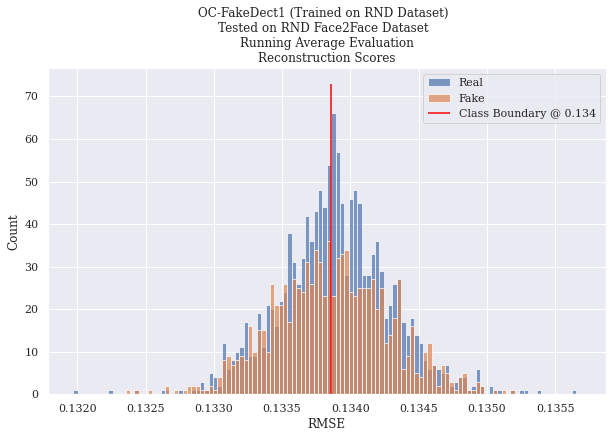

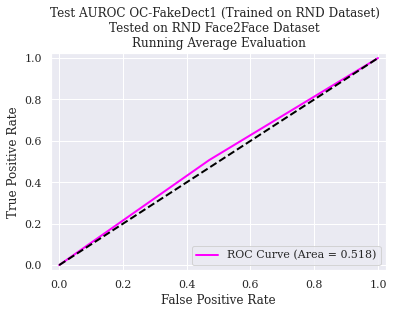

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND Face2Face Dataset
OC-FakeDect1_RND
Face2Face_rnd
OC-FakeDect1_RND_F2Frnd




100%|██████████| 18038/18038 [01:03<00:00, 282.78it/s]


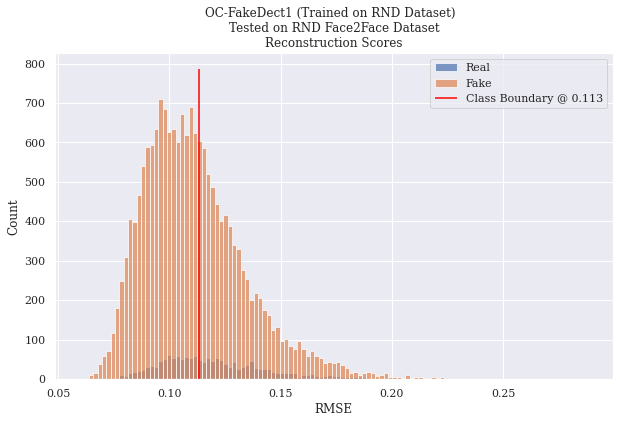

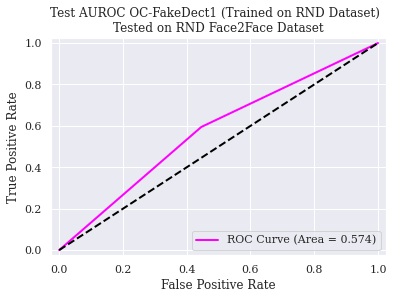

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG FaceShifter Dataset  
Running Average Evaluation
OC-FakeDect1_RND
FaceShifter_avg
OC-FakeDect1_RND_raeonFSHFTavg




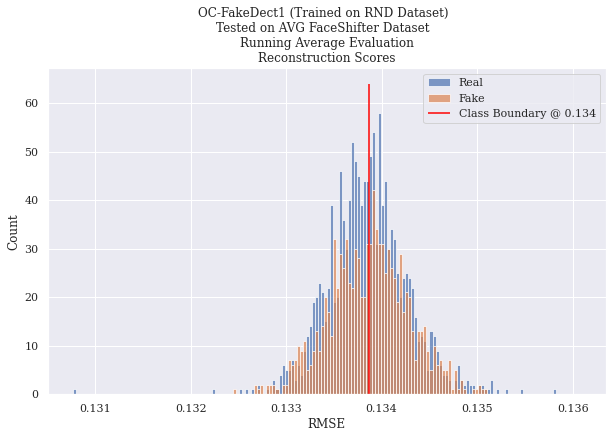

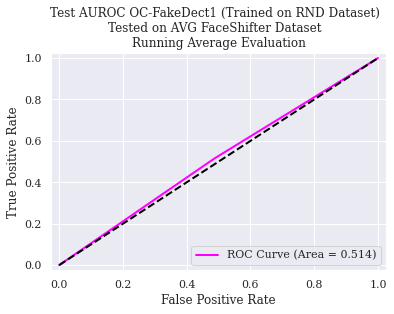

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG FaceShifter Dataset
OC-FakeDect1_RND
FaceShifter_avg
OC-FakeDect1_RND_FSHFTavg




100%|██████████| 18038/18038 [01:04<00:00, 280.21it/s]


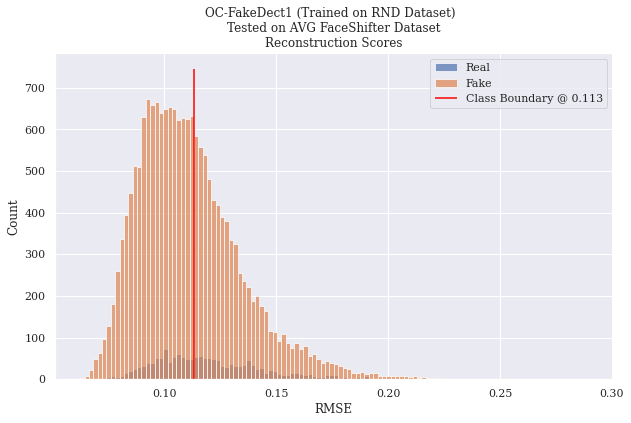

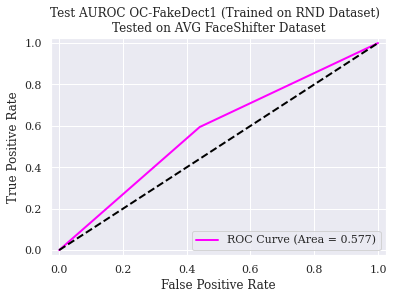

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND FaceShifter Dataset  
Running Average Evaluation
OC-FakeDect1_RND
FaceShifter_rnd
OC-FakeDect1_RND_raeonFSHFTrnd




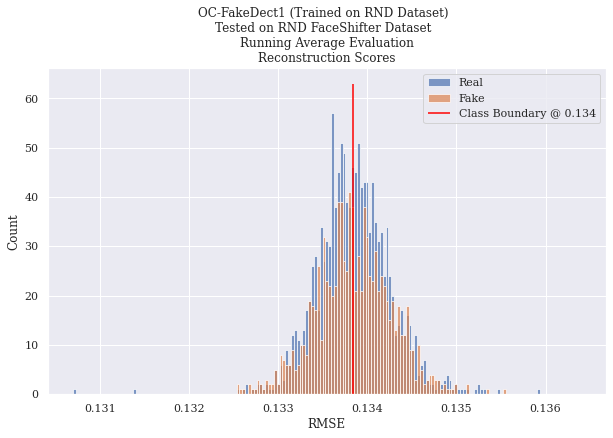

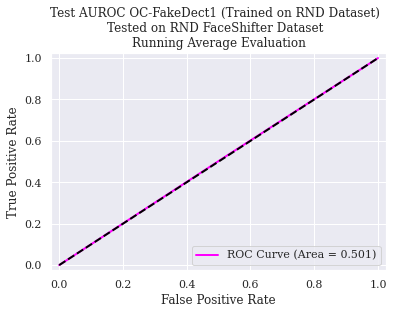

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND FaceShifter Dataset
OC-FakeDect1_RND
FaceShifter_rnd
OC-FakeDect1_RND_FSHFTrnd




100%|██████████| 18038/18038 [01:04<00:00, 279.72it/s]


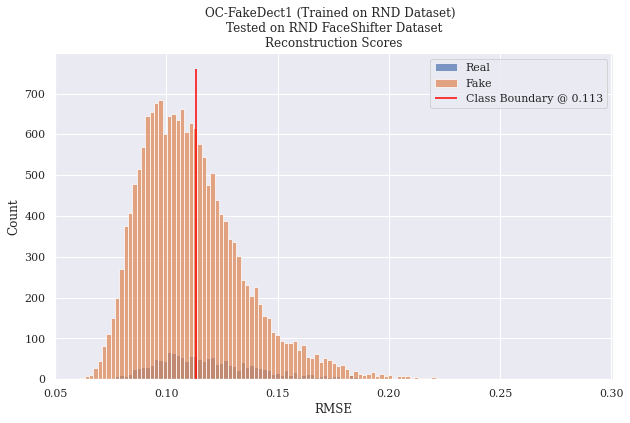

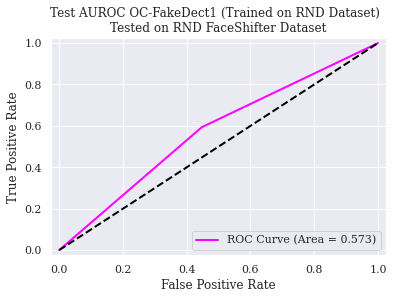

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG FaceSwap Dataset  
Running Average Evaluation
OC-FakeDect1_RND
FaceSwap_avg
OC-FakeDect1_RND_raeonFSavg




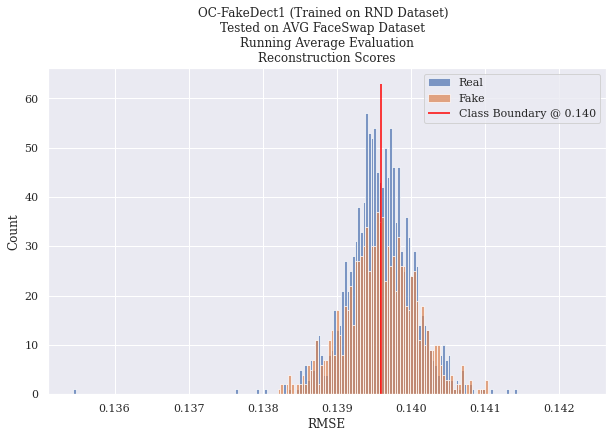

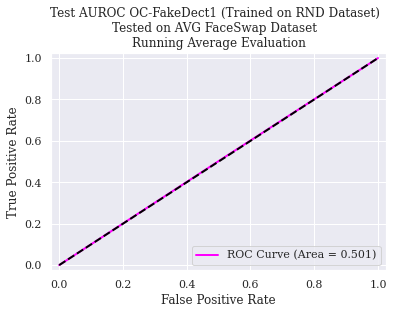

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG FaceSwap Dataset
OC-FakeDect1_RND
FaceSwap_avg
OC-FakeDect1_RND_FSavg




100%|██████████| 18038/18038 [01:03<00:00, 282.76it/s]


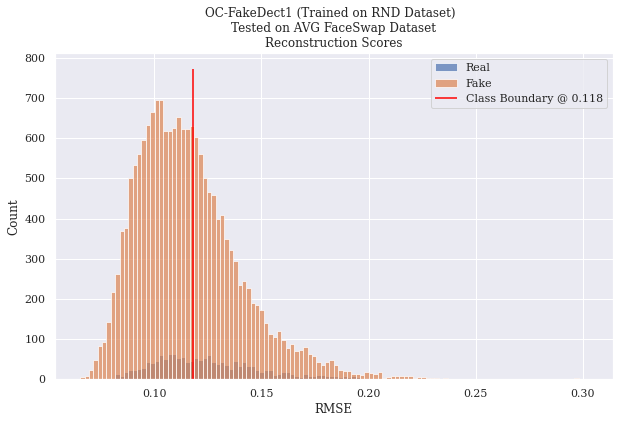

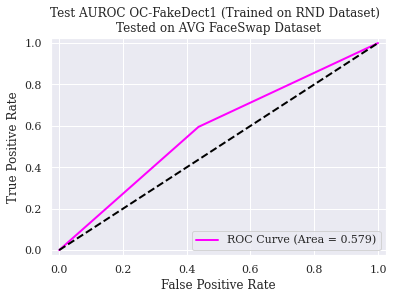

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND FaceSwap Dataset  
Running Average Evaluation
OC-FakeDect1_RND
FaceSwap_rnd
OC-FakeDect1_RND_raeonFSrnd




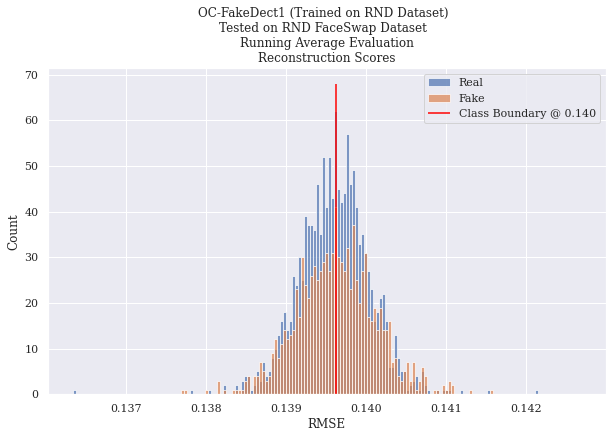

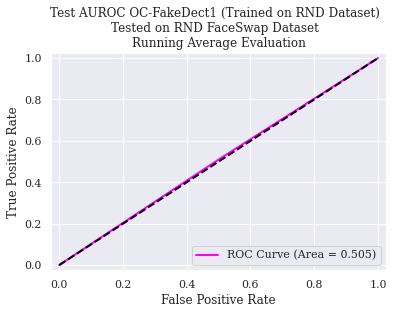

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND FaceSwap Dataset
OC-FakeDect1_RND
FaceSwap_rnd
OC-FakeDect1_RND_FSrnd




100%|██████████| 18038/18038 [01:03<00:00, 282.81it/s]


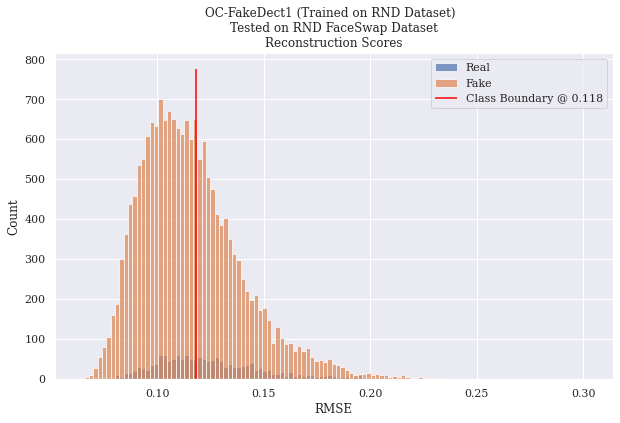

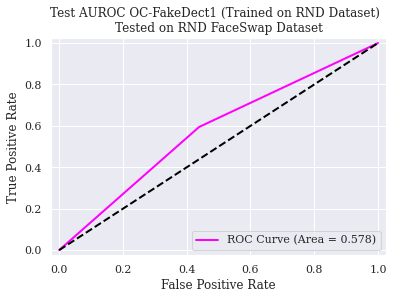

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG NeuralTextures Dataset  
Running Average Evaluation
OC-FakeDect1_RND
NeuralTextures_avg
OC-FakeDect1_RND_raeonNTavg




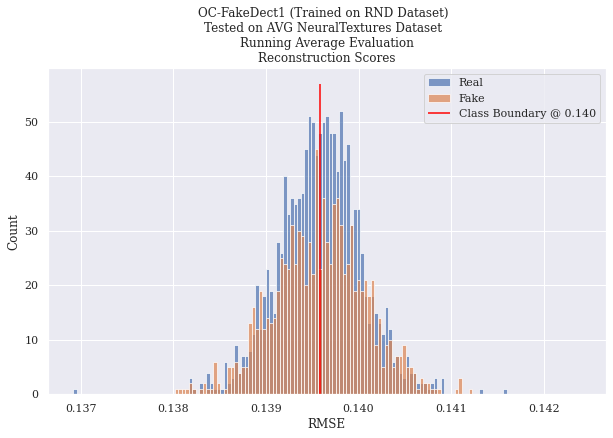

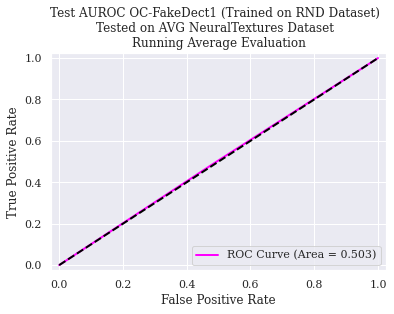

OC-FakeDect1 (Trained on RND Dataset)  
Tested on AVG NeuralTextures Dataset
OC-FakeDect1_RND
NeuralTextures_avg
OC-FakeDect1_RND_NTavg




100%|██████████| 18038/18038 [01:05<00:00, 274.53it/s]


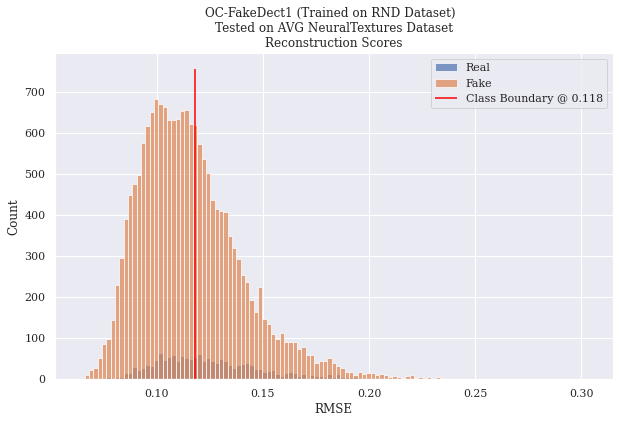

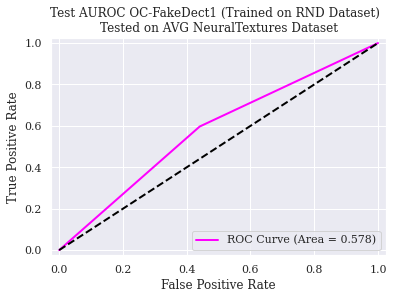

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND NeuralTextures Dataset  
Running Average Evaluation
OC-FakeDect1_RND
NeuralTextures_rnd
OC-FakeDect1_RND_raeonNTrnd




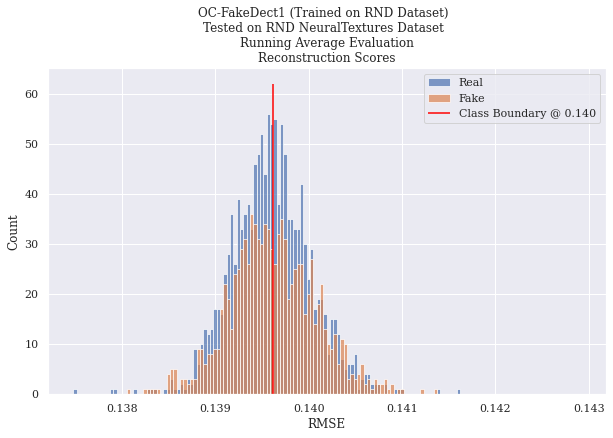

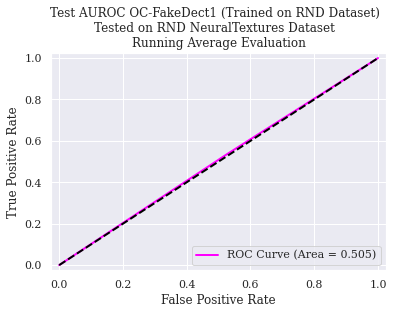

OC-FakeDect1 (Trained on RND Dataset)  
Tested on RND NeuralTextures Dataset
OC-FakeDect1_RND
NeuralTextures_rnd
OC-FakeDect1_RND_NTrnd




100%|██████████| 18038/18038 [01:03<00:00, 282.03it/s]


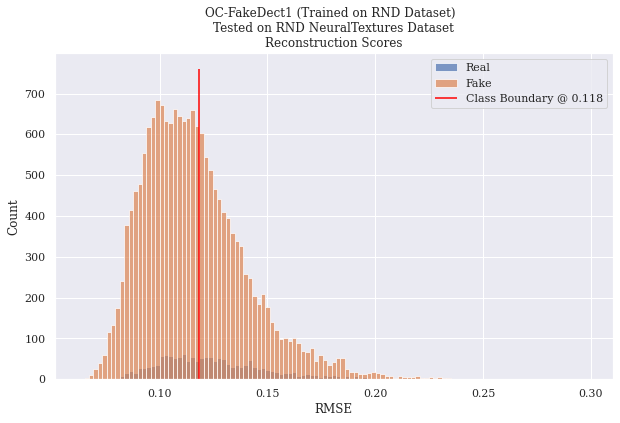

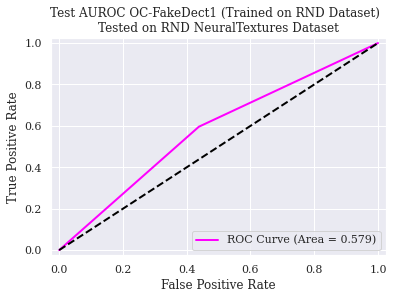

In [15]:
for experiment_name, model_name, testset_name, fname in EXPERIMENTS:
    print(experiment_name, model_name, testset_name, fname, "\n", sep="\n")
    _, _, trainset = get_binary_testset(testset_name)

    # recon scores
    test_n = sum([len(files) for _, _, files in os.walk(trainset)]) #// batch_size
    score = {0:[],1:[]}
    avg_eval = "running" in experiment_name.lower()
    if avg_eval:
        # running average eval, set of images from each video is single data point (not indep.)
        path_to_testset_real_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' in d][0]}"
        path_to_testset_fake_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' not in d][0]}"

        for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
            img_dir_list = os.listdir(y_dir_pth)
            Vpths = []
            # loop over all single videos
            for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

                all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
                path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
                rsmeS = []

                # loop over all frames from single video
                for path_to_test_img in path_all_imgs_for_vid:
                    image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
                    image = transform_test(image)
                    image = image.float().to(device)

                    fakedect.eval() # test mode
                    with torch.no_grad():
                        x = image.view(-1,3,100,100)
                        x_prime, _, _ = fakedect(x)
                        # z_mean, z_logvar = fakedect.encode(x_prime)
                        xi = x.flatten()
                        xo = x_prime.flatten()
                    rsmeS += [((((xi.cpu() - xo.cpu())**2).sum()/test_n)**0.5).item()]
                score[y_label] += [np.average(rsmeS)]

    else:
        for class_dir in os.listdir(f"{testset}/"):
            y = 0 if "real" in class_dir else 1
            for test_img in tqdm(os.listdir(f"{testset}/{class_dir}")):
                test_img_path = f"{testset}/{class_dir}/{test_img}"
                if ".png" in test_img_path or ".jpg" in test_img_path or ".jpeg" in test_img_path:
                    image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
                    image = transform_test(image)
                    image = image.float().to(device)

                    fakedect.eval() # test mode
                    with torch.no_grad():
                        x = image.view(-1,3,100,100)
                        x_prime, _, _ = fakedect(x)
                        # z_mean, z_logvar = fakedect.encode(x_prime)
                        xi = x.flatten()
                        xo = x_prime.flatten()
                    rsme = ((((xi.cpu() - xo.cpu())**2).sum()/test_n)**0.5).item()
                    score[y] += [rsme]
    
    k = max(np.array(score[0]).std() * 0.075, np.array(score[1]).std() * 0.075)
    min_r, max_r = min(min(score[0]), min(score[1])), max(max(score[0]), max(score[1]))
    bins = [x for x in np.arange(min_r, max_r, k)]

    try:
        threshold = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))[0]
    except LinAlgError:
        threshold = (min_r+max_r)/2

    figure(figsize = (10, 6))#, dpi = 80)
    c0,_,p = plt.hist(score[0], bins, alpha=0.7, label="Real")
    c1,_,p = plt.hist(score[1], bins, alpha=0.7, label="Fake")
    plt.vlines(threshold, 0, int(max(max(c0),max(c1))//0.9), colors="red", label=f"Class Boundary @ {threshold:.3f}" )
    plt.legend()
    plt.xlabel("RMSE")
    plt.ylabel("Count")
    plt.title(f"{experiment_name}\nReconstruction Scores")
    plt.savefig(f"Results/recon_{dataset_name}.pdf")
    plt.show()

    y_true = np.array([0]*len(score[0]) + [1]*len(score[1]))
    y_pred = np.array(score[0] + score[1])
    y_pred_rint = (y_pred <= threshold).astype(float)
    y_pred = y_pred_rint

    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _  = roc_curve(y_true, y_pred)

    # If model is worse than random but so much worse that, it's predicting the opposite way
    if auroc < .5:
        auroc = 1 - auroc
        fpr, tpr = tpr, fpr
        y_pred = np.ones(y_pred.shape) - y_pred

    # Get F1, Precision and Recall
    f1 = f1_score(y_true, y_pred_rint)
    prec = precision_score(y_true, y_pred_rint)
    recall = recall_score(y_true, y_pred_rint)

    # Plot AUC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Test AUROC {experiment_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"./Results/{fname}_AUC.pdf")
    plt.show()

    with open(f"./Results/{fname}.txt", "w") as f:
        f.write(f"{experiment_name, model_name, dataset_name, fname}\n")
        f.write(f"auroc={auroc}\n")
        f.write(f"f1={f1}\n")
        f.write(f"prec={prec}\n")
        f.write(f"recall={recall}\n")
        f.write(f"\nfpr={[f for f in fpr]}\n")
        f.write(f"\ntpr={[t for t in tpr]}\n")
        f.write(f"\ny_true={[t for t in y_true]}\n")
        f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}\n")
        f.write(f"\score={score}")
    # break